In [42]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [43]:
def parse_xml(xml_file):
    """Parse le fichier XML et extrait les coordonnées de la bounding box."""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    
    for obj in root.iter('object'):
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
    
    return boxes

def load_images_and_boxes(image_dir, xml_dir, target_size=(256, 256)):
    images = []
    boxes = []

    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        xml_path = os.path.join(xml_dir, image_file.replace('.png', '.xml'))  # Assumer que chaque image a un fichier XML correspondant

        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, target_size)

        box = parse_xml(xml_path)

        images.append(image)
        boxes.append(box)

    return np.array(images), np.array(boxes)


In [44]:
# Exemple d'utilisation
image_dir = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset/martensite microstructure/converted_to_png/'
xml_dir = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset/martensite microstructure/converted_to_png/'
X_train, Y = load_images_and_boxes(image_dir, xml_dir)


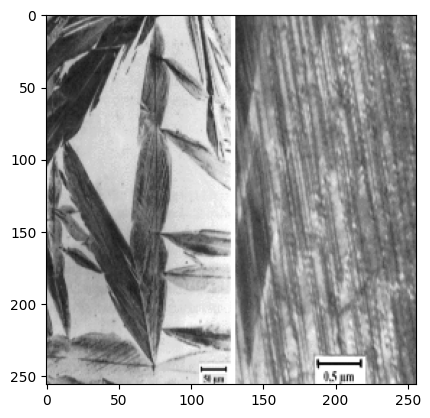

In [45]:
plt.imshow(X_train[6])

In [46]:
Y[6]

array([[259,  14, 471, 300]])

In [47]:
X_train_scaled = X_train.astype('float32') / 255.0

In [60]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Concatenate, Conv2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

def create_ssd_model(num_classes, img_size=(256, 256, 3)):
    base_model = MobileNetV2(input_shape=img_size, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Réduire les dimensions pour la couche Dense
        Dense(4, activation='sigmoid')  # Spécifier l'activation pour la prédiction des coordonnées
    ])

    return model

# Création du modèle
model = create_ssd_model(num_classes=1)  # num_classes n'est plus utilisé ici

# Compiler le modèle
model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_7 ( (None, 1280)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [61]:
Y_reshaped = Y.reshape(-1,1,4)  # Change la forme de (62, 1, 4) à (62, 4)

In [62]:
Y = Y.reshape(-1,4)  # Change la forme de (62, 1, 4) à (62, 4)

In [63]:
Y.shape

(62, 4)

In [64]:
history = model.fit(X_train_scaled, Y, epochs=100, batch_size=6)

Epoch 1/100
11/11 [==============================] - 2s 19ms/step - loss: 198513.1719
Epoch 2/100
11/11 [==============================] - 0s 18ms/step - loss: 198403.1250
Epoch 3/100
11/11 [==============================] - 0s 18ms/step - loss: 198396.9688
Epoch 4/100
11/11 [==============================] - 0s 18ms/step - loss: 198396.2188
Epoch 5/100
11/11 [==============================] - 0s 18ms/step - loss: 198395.8906
Epoch 6/100
11/11 [==============================] - 0s 18ms/step - loss: 198395.7969
Epoch 7/100
11/11 [==============================] - 0s 18ms/step - loss: 198395.6875
Epoch 8/100
11/11 [==============================] - 0s 18ms/step - loss: 198395.6250
Epoch 9/100
11/11 [==============================] - 0s 18ms/step - loss: 198395.5625
Epoch 10/100
11/11 [==============================] - 0s 18ms/step - loss: 198395.5312
Epoch 11/100
11/11 [==============================] - 0s 17ms/step - loss: 198395.4844
Epoch 12/100
11/11 [==============================] 

In [53]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def draw_bbox(image, bbox, color='red'):
    """Dessine un bounding box sur une image."""
    # Créer une figure et un axe
    fig, ax = plt.subplots(1)
    # Afficher l'image
    ax.imshow(image)
    # Ajouter un rectangle pour le bounding box
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=2, edgecolor=color, facecolor='none')
    ax.add_patch(rect)
    plt.show()


In [65]:
test_image = X_train_scaled[0]  # Prendre la première image pour l'exemple


In [66]:
test_image.shape

(256, 256, 3)

In [67]:
# Prédire la bounding box
pred_box = model.predict(np.expand_dims(test_image, axis=0)) # Ajoutez une nouvelle dimension et prenez la première prédiction


In [68]:
pred_box

array([[0.9999671 , 0.99987996, 0.9999423 , 0.9999609 ]], dtype=float32)

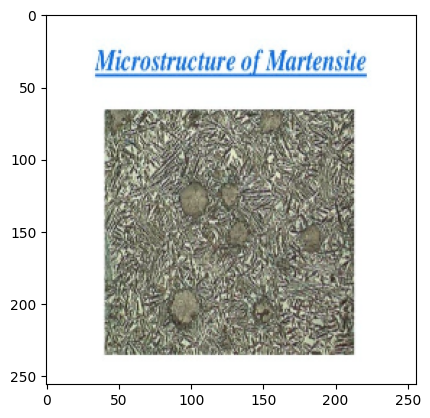

In [69]:
plt.imshow(test_image)

In [70]:
Y[0]

array([115, 133, 519, 434])